# Classifying images with Deep Convolutional Neural Networks

# We will discuss following topics:

-  Convolution operations in one and two dimensions
-  The building blocks of CNN architectures
-  Implementing deep CNNs in PyTorch
-  Data augmentation techniques for improving the generalization performance
-  Implementing a facial CNN classifier for recognizing if someone is smiling or not

CNNs can automatically learn the features from raw data -- Hence, it is common to consider CNN layers as feature extractors.

Deep CNNs construct a so-called feature hierarchy by combining low-level features in a layer-wise fashion to form high-level features.

**Example:** <br>
With images, the low-level features, such as edges and blobs, are extracted from the <br>
earlier layers, which are combined to form high-level features. These high-level features can form <br>
more complex shapes, such as the general contours of objects like buildings, cats, or dogs.

In [6]:
from IPython.display import Image
%matplotlib inline

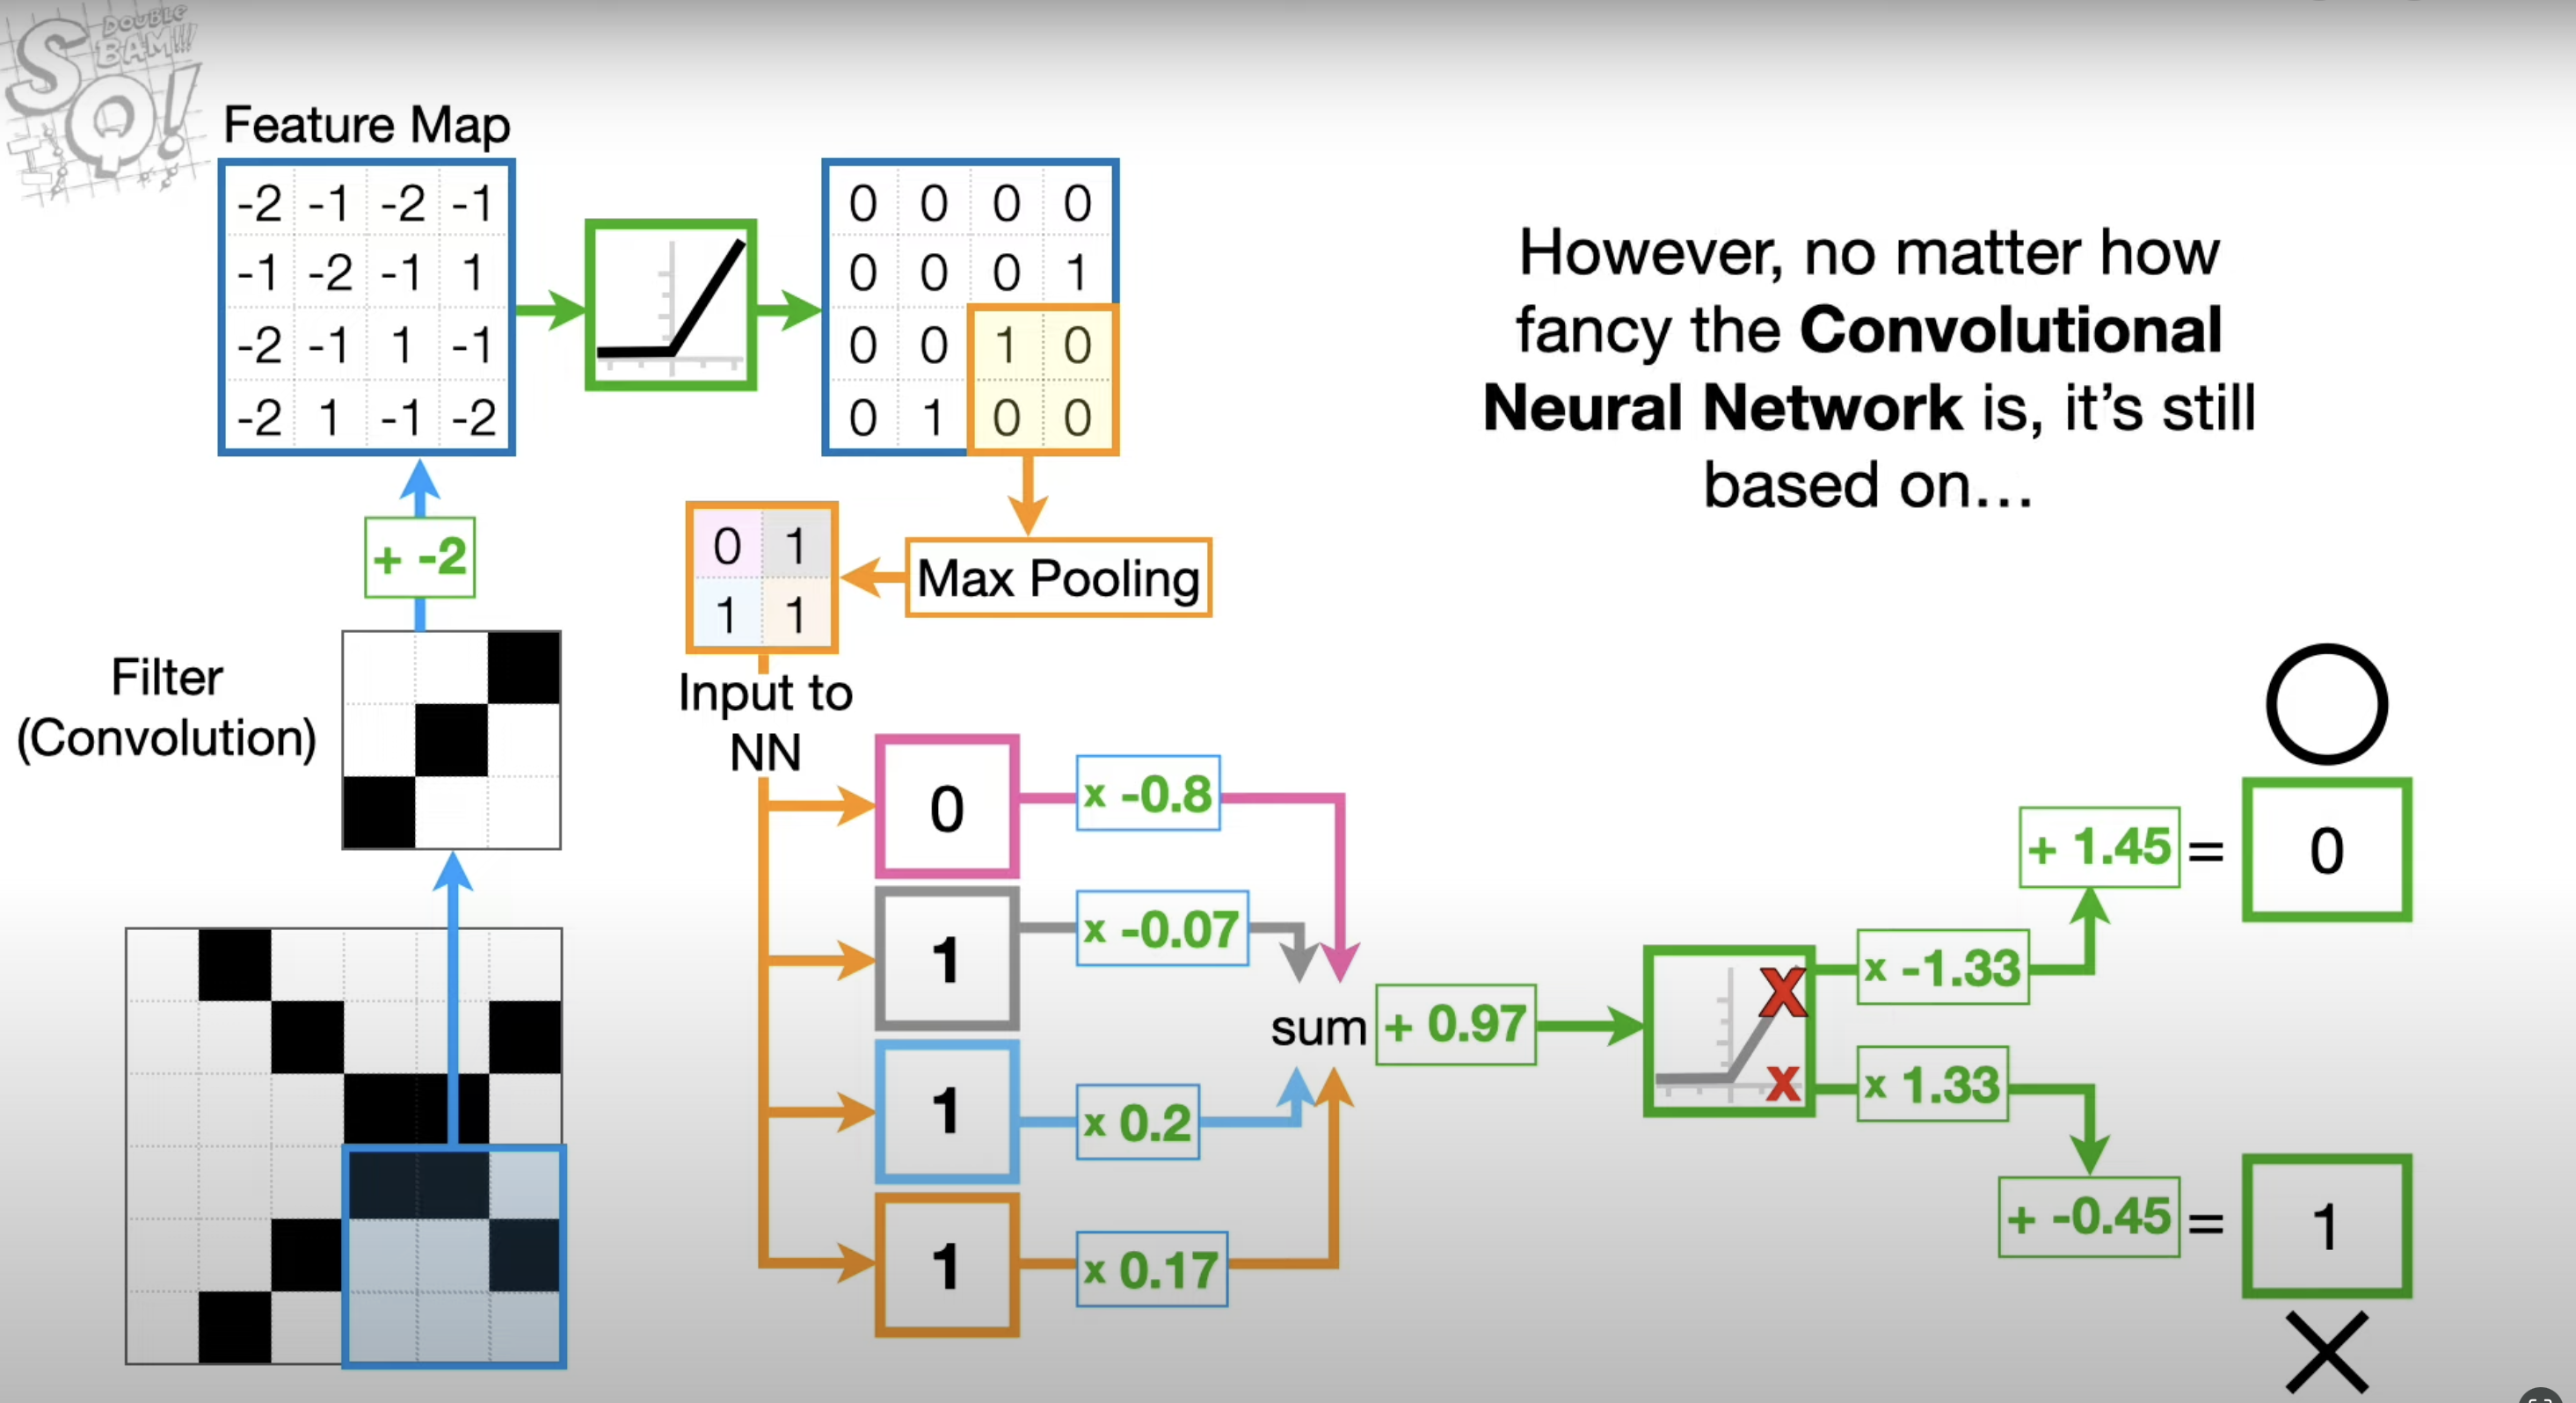

In [7]:
Image(filename='/Users/akshaykore/Downloads/Workspace/ML_Raschka/chapter_14/Statquest_ss.png')

## Naive implementation of computing convolutions in one dimension

In [2]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, (int((len(x_padded) - len(w_rot))/s) + 1) * s, s):
        res.append(np.sum(
            x_padded[i:i + w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


## Performing a discrete convolution in 2D

In [3]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, (int((X_padded.shape[0] -
                            W_rot.shape[0]) / s[0]) + 1) * s[0], s[0]):
        res.append([])
        for j in range(0, (int((X_padded.shape[1] -
                                W_rot.shape[1]) / s[1]) + 1) * s[1], s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0],
                    j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Reading an image file in torch

In [5]:
import torch
from torchvision.io import read_image

img = read_image('/Users/akshaykore/Downloads/Workspace/ML_Raschka/chapter_14/example-image.png')

print('Image shape:', img.shape)
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print(img[:, 100:102, 100:102])

Image shape: torch.Size([3, 252, 221])
Number of channels: 3
Image data type: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


In [8]:
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

100.0%
100.0%
100.0%
100.0%


In [9]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

## Constructing a CNN in pytorch

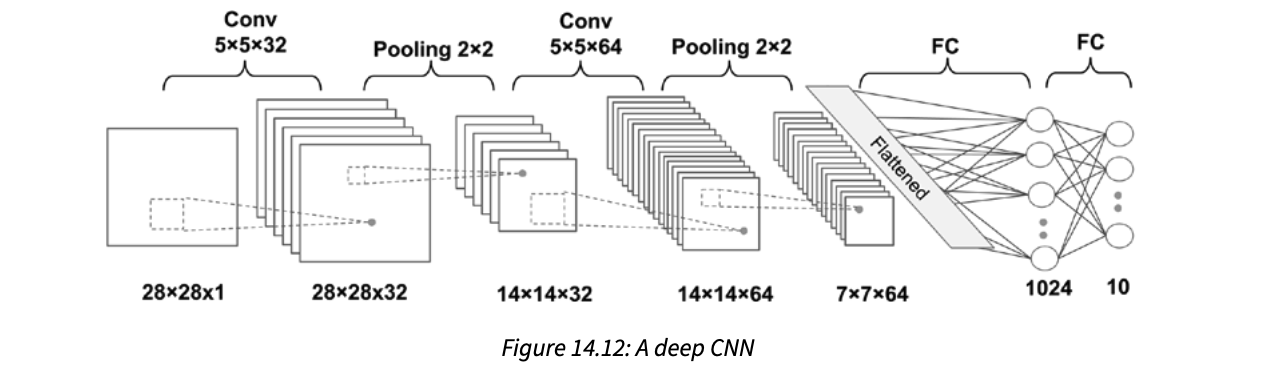

In [10]:
Image(filename='/Users/akshaykore/Downloads/Workspace/ML_Raschka/chapter_14/DeepCNN.png')

In [12]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 

In [13]:
# device = torch.device('cuda:0')
device = torch.device('cpu')

model = model.to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9483 val_accuracy: 0.9807
Epoch 2 accuracy: 0.9836 val_accuracy: 0.9838
Epoch 3 accuracy: 0.9884 val_accuracy: 0.9887
Epoch 4 accuracy: 0.9915 val_accuracy: 0.9885
Epoch 5 accuracy: 0.9929 val_accuracy: 0.9884
Epoch 6 accuracy: 0.9945 val_accuracy: 0.9869
Epoch 7 accuracy: 0.9950 val_accuracy: 0.9902
Epoch 8 accuracy: 0.9959 val_accuracy: 0.9887
Epoch 9 accuracy: 0.9961 val_accuracy: 0.9899
Epoch 10 accuracy: 0.9969 val_accuracy: 0.9876
Epoch 11 accuracy: 0.9972 val_accuracy: 0.9910
Epoch 12 accuracy: 0.9971 val_accuracy: 0.9888
Epoch 13 accuracy: 0.9970 val_accuracy: 0.9906
Epoch 14 accuracy: 0.9977 val_accuracy: 0.9895
Epoch 15 accuracy: 0.9979 val_accuracy: 0.9893
Epoch 16 accuracy: 0.9976 val_accuracy: 0.9893
Epoch 17 accuracy: 0.9979 val_accuracy: 0.9905
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9912
Epoch 19 accuracy: 0.9989 val_accuracy: 0.9907
Epoch 20 accuracy: 0.9981 val_accuracy: 0.9902


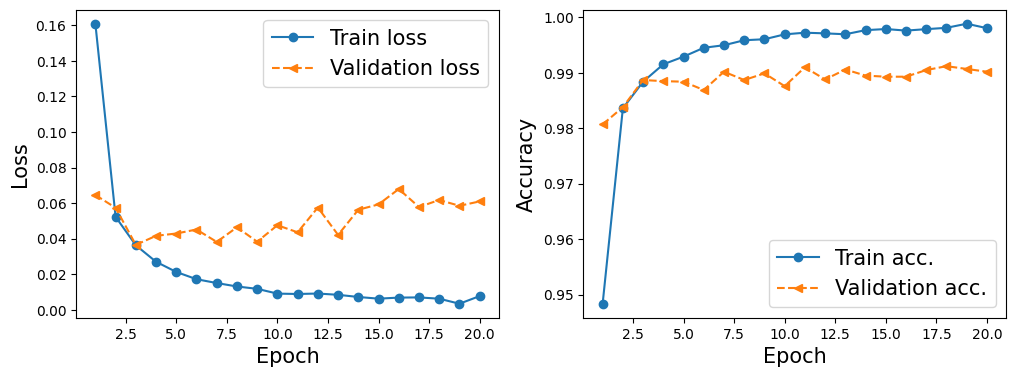

In [15]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [16]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9923


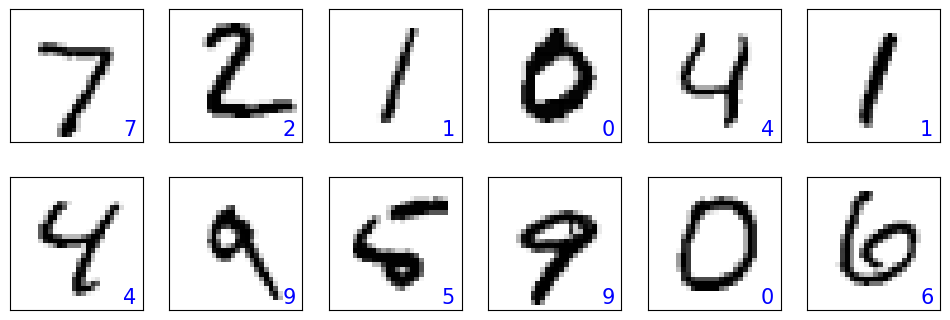

In [17]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()

In [19]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)